In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from functools import reduce

In [2]:
EXPERIMENT_RESULT_FOLDER = "../../experiments"

MAP_PATH = "omni3ros_pkg/maps/maze.jpeg"
MAP_RESOLUTION = 0.05 # meters / pixel
MAP_ORIGIN = [-12.200000, -15.400000, 0.000000]

#### Read experiment file

In [3]:
experiment_filenames = sorted(os.listdir(EXPERIMENT_RESULT_FOLDER))
experiment_filenames

['path_planning_data_1.pickle',
 'path_planning_data_2.pickle',
 'path_planning_data_3.pickle']

In [4]:
filename = experiment_filenames[1]
filename

'path_planning_data_2.pickle'

In [5]:
with open(os.path.join(EXPERIMENT_RESULT_FOLDER, filename), "rb") as f:
    data = pickle.load(f)

In [6]:
start_time = data["start_time"]
end_time = data["end_time"]
odometry = data["odometry"]

In [7]:
X, Y, THETA, DX, DY, DTHETA, TIME = list(zip(*odometry))

#### Calculate statistics

In [8]:
spent_time = end_time - start_time
spent_time

113.30056427999807

In [9]:
def draw_speed(DX, DY, DTHETA):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    linear_speed = [np.sqrt(dx ** 2 + dy ** 2) for dx, dy in zip(DX, DY)] 
    ax1.plot(linear_speed)
    ax1.set_title("Linear speed profile")
    ax1.set_ylabel("Speed (m/s)")
    
    ax2.plot(DTHETA)
    ax2.set_title("Angular speed profile")
    ax2.set_ylabel("Speed (m/s)")
    
    plt.show()

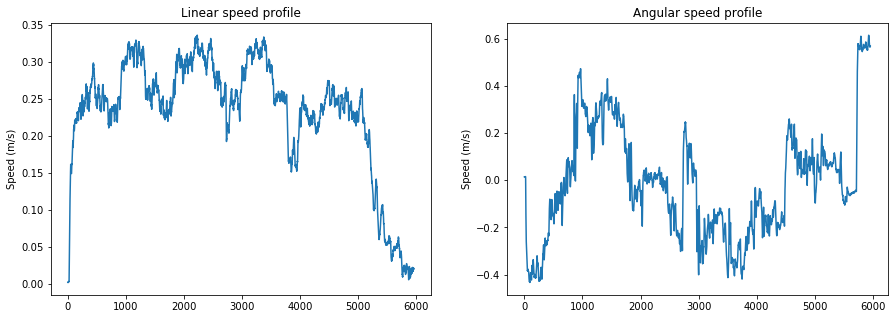

In [10]:
draw_speed(DX, DY, DTHETA)

By second plot we see that we do rotations during linear movement which is good

In [28]:
def draw_acceleration(DX, DY, DTHETA, TIME):
    fig, ax = plt.subplots()
    
    linear_speed = [np.sqrt(dx ** 2 + dy ** 2) for dx, dy in zip(DX, DY)] 
    
    acceleration = []

    for i in range(1, len(linear_speed)):
        dv = linear_speed[i] - linear_speed[i-1]
        dt = TIME[i] - TIME[i-1]
        acceleration.append(dv / dt)
    
    ax.plot(acceleration)
    ax.set_title("Acceleration profile")
    ax.set_ylabel("Acceleration (m/s2)")
    
    
    plt.show()

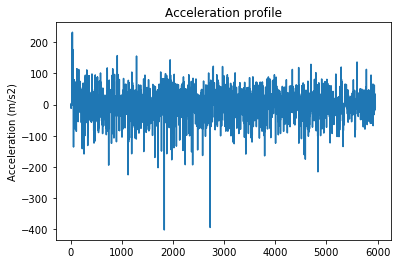

In [12]:
draw_acceleration(DX, DY, DTHETA)

In [13]:
def calculate_path_length(X, Y):
    def l2_dist(point1, point2):
        return np.sqrt((point2[1] - point1[1]) ** 2 + (point2[0] - point1[0]) ** 2)

    length = 0
    for i in range(1, len(X)):
        length += l2_dist((X[i], Y[i]), (X[i-1], Y[i-1]))
    return length

In [14]:
calculate_path_length(X, Y)

13.865047730246284

#### Draw path

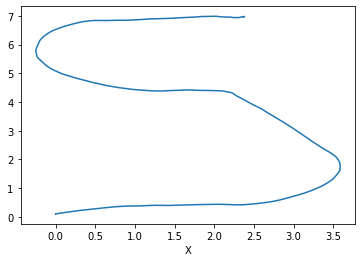

In [15]:
plt.plot(X, Y)
plt.xlabel("X")
plt.show()

In [16]:
img_map = Image.open(MAP_PATH).rotate(90)

In [17]:
origin_in_pixels = [val / MAP_RESOLUTION for val in MAP_ORIGIN]
origin_in_pixels

[-243.99999999999997, -308.0, 0.0]

In [18]:
x_origin = 243
y_origin = 308

# x_origin = 308
# y_origin = 243

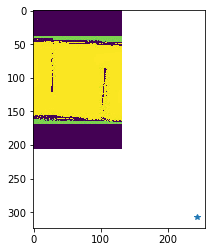

In [19]:
plt.imshow(img_map)

plt.plot(x_origin, y_origin, "*")
plt.show()

In [20]:
img_map = Image.open(MAP_PATH)

In [21]:
img_map.size

(132, 207)

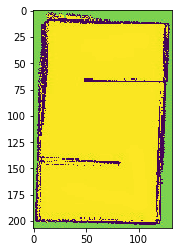

In [22]:
plt.imshow(img_map)

# plt.plot(x_origin, y_origin, "*")
plt.show()

In [23]:
x_origin_shift_px = 30
y_origin_shift_px = 30

In [24]:
def adapt_y(y, height=img_map.size[1]):
    # Arg y have to be in pixels
    return height - y

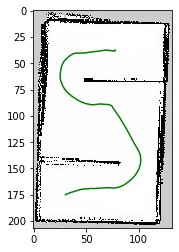

In [25]:
plt.imshow(img_map, cmap="gray")

x_plot = [x / MAP_RESOLUTION + x_origin_shift_px for x in X]
y_plot = [adapt_y(y / MAP_RESOLUTION + y_origin_shift_px) for y in Y]
    
plt.plot(x_plot, y_plot, "g")

plt.show()

### Combine all statistics

In [34]:
def assess_path_planning_algorithm(filename):
    with open(os.path.join(EXPERIMENT_RESULT_FOLDER, filename), "rb") as f:
        data = pickle.load(f)
        
    start_time = data["start_time"]
    end_time = data["end_time"]
    odometry = data["odometry"]
    
    X, Y, THETA, DX, DY, DTHETA, TIME = list(zip(*odometry))
    
    spent_time = end_time - start_time
    path_length = calculate_path_length(X, Y)
    print(f"Spent {spent_time:0.3f}s., path length is {path_length:0.3f}m.")
    
    draw_speed(DX, DY, DTHETA)
    
    draw_acceleration(DX, DY, DTHETA, TIME)


path_planning_data_1.pickle
Spent 199.280s., path length is 14.999m.


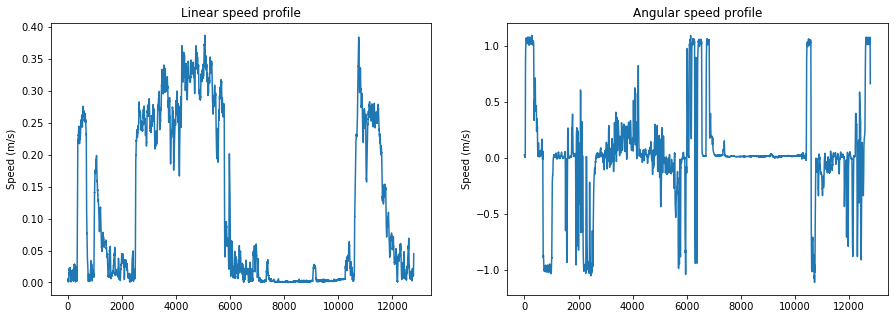

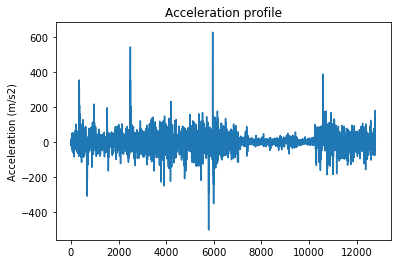


path_planning_data_2.pickle
Spent 113.301s., path length is 13.865m.


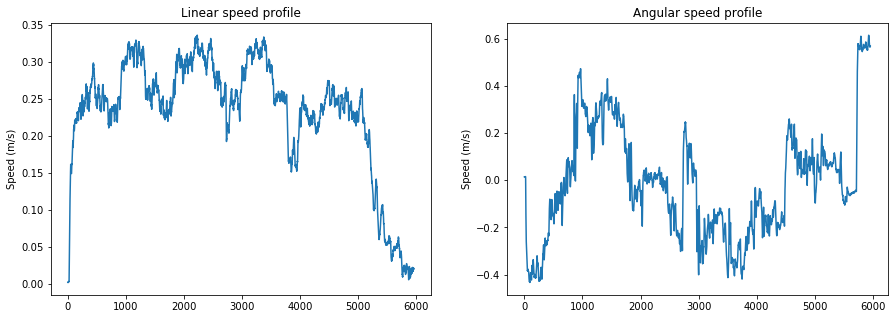

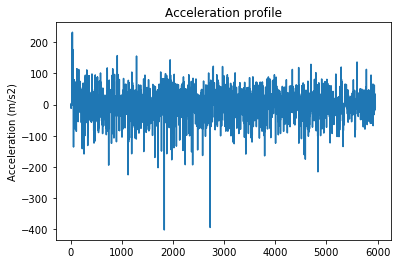


path_planning_data_3.pickle
Spent 28.047s., path length is 12.807m.


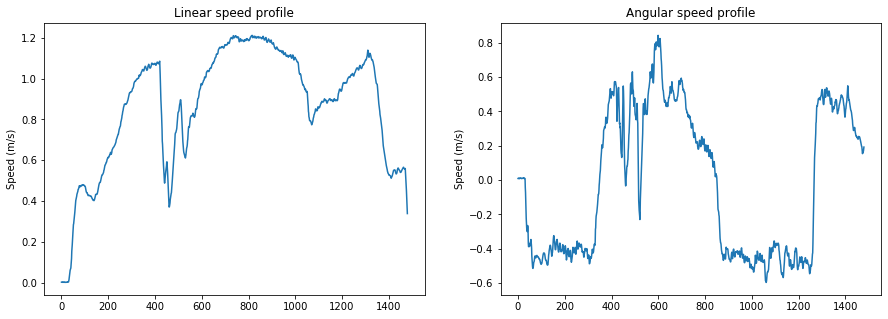

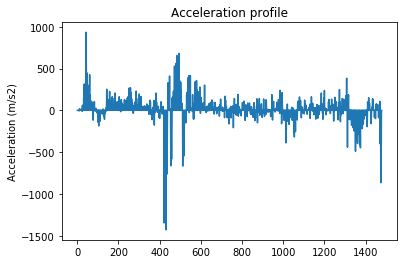

In [35]:
for filename in experiment_filenames:
    print(f"\n\n{filename}")
    assess_path_planning_algorithm(filename)

In [58]:
def draw_paths(odometry_list, map_path, map_resolution, labels):
    plt.figure(figsize=(10, 10))
    x_origin_shift_px = 30
    y_origin_shift_px = 30

    img_map = Image.open(map_path)
    plt.imshow(img_map, cmap="gray")
    
    def adapt_y(y, height=img_map.size[1]):
        # Arg y have to be in pixels
        return height - y



    for odometry, label in zip(odometry_list, labels):
        X, Y, THETA, DX, DY, DTHETA, TIME = list(zip(*odometry))
        
        x_plot = [x / map_resolution + x_origin_shift_px for x in X]
        y_plot = [adapt_y(y / map_resolution + y_origin_shift_px) for y in Y]

        plt.plot(x_plot, y_plot, label=label)

    plt.legend()
    plt.show()

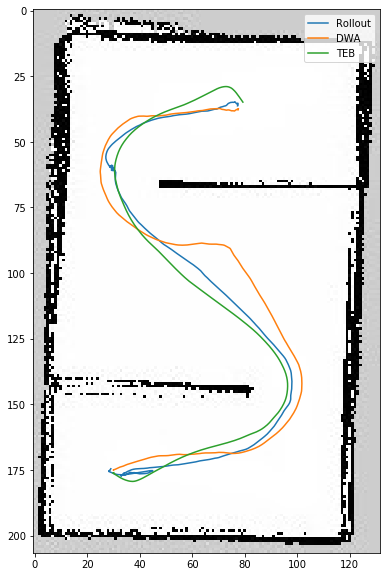

In [59]:
odometry_list = []
labels = ["Rollout", "DWA", "TEB"] # TODO extract from file

for filename in experiment_filenames:
    with open(os.path.join(EXPERIMENT_RESULT_FOLDER, filename), "rb") as f:
        data = pickle.load(f)
        odometry_list.append(data["odometry"])


draw_paths(odometry_list, MAP_PATH, MAP_RESOLUTION, labels)